In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import numpy as np
import pandas as pd
import re
import torch

In [53]:
train_set = pd.read_csv('data/Price_euros_train.csv')
test_set = pd.read_csv('data/Price_euros_test.csv')
sub_set = pd.read_csv('data/Sample_submition.csv')
train_set

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
1,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
2,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
3,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00
4,7,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS X,2.04kg,2139.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1315,Asus,X556UJ-XO044T (i7-6500U/4GB/500GB/GeForce,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,4GB,500GB HDD,Nvidia GeForce 920M,Windows 10,2.2kg,720.32
1104,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1105,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1106,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00


In [3]:
def delete_null_rows(dataframe):
    cleaned_df = dataframe.dropna()
    print(f"Rows removed: {len(dataframe) - len(cleaned_df)}")
    return cleaned_df
def auto_fill_nulls(dataframe):
    filled_df = dataframe.copy()
    for column in filled_df.columns:
        if filled_df[column].isnull().sum() > 0:  
            if np.issubdtype(filled_df[column].dtype, np.number):
                median_value = filled_df[column].median()
                filled_df[column].fillna(median_value, inplace=True)
                print(f"Filled nulls in numeric column '{column}' with median value: {median_value}")
            else:
                top_3_values = filled_df[column].value_counts().index[:3]
                if len(top_3_values) > 0:  
                    random_choice = np.random.choice(top_3_values)
                    filled_df[column].fillna(random_choice, inplace=True)
                    print(f"Filled nulls in non-numeric column '{column}' with random choice from top 3: {random_choice}")
                else:
                    print(f"Column '{column}' has no valid non-null values to use for filling.")
    return filled_df

In [ ]:
import re
import numpy as np
import pandas as pd

def simplify_company(df):
    if 'Product' not in df.columns:
        return df
    df = df.copy()
    df['ProductCategory'] = df['Company'].str.extract(r'([A-Za-z]+)', expand=False).str.lower()
    freq = df['ProductCategory'].value_counts()
    df['ProductCategory'] = df['ProductCategory'].map(freq)
    df.drop(columns=['Company'], inplace=True)
    return df


# ✔ RAM: "8GB" → 8.0
def RAM_to_float(df):
    if 'Ram' in df.columns:
        df = df.copy()
        df['Ram'] = df['Ram'].str.extract(r'(\d+)').astype(float)
    return df

# ✔ Weight: "1.8kg" → 1.8
def weight_to_float(df):
    if 'Weight' in df.columns:
        df = df.copy()
        df['Weight'] = df['Weight'].str.replace('kg', '', regex=False).astype(float)
    return df

# ✔ GPU: broad grouping
def gpu_to_int(df):
    if 'Gpu' in df.columns:
        df = df.copy()
        conditions = [
            df['Gpu'].str.contains('intel', case=False, na=False),
            df['Gpu'].str.contains('amd', case=False, na=False),
            df['Gpu'].str.contains('nvidia', case=False, na=False),
        ]
        choices = [1, 2, 3]
        df['Gpu'] = np.select(conditions, choices, default=0).astype(int)
    return df

# ✔ CPU frequency extraction: "2.5GHz" → 2.5
def cpu_to_freq(df):
    if 'Cpu' in df.columns:
        df = df.copy()
        df['Cpu'] = df['Cpu'].str.extract(r'(\d+(?:\.\d+)?)\s*GHz', expand=False)
        df['Cpu'] = pd.to_numeric(df['Cpu'], errors='coerce')
    return df

# ✔ Screen resolution size category
def screen_resolution_to_bins(df):
    if 'ScreenResolution' in df.columns:
        df = df.copy()
        match = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)', expand=True)
        match = match.apply(pd.to_numeric, errors='coerce')
        df['ResolutionArea'] = match[0] * match[1]
        df['ResolutionCategory'] = df['ResolutionArea'].apply(
            lambda x: 1 if x < 2073600 else (2 if x == 2073600 else 3)
        )
        df.drop(columns=['ScreenResolution', 'ResolutionArea'], inplace=True)
    return df

# ✔ Memory: separate SSD, HDD, Flash in GB
def memory_to_features(df):
    if 'Memory' not in df.columns:
        return df

    def parse_memory(mem_str):
        parts = str(mem_str).lower().split('+')
        hdd = ssd = flash = 0
        for part in parts:
            size_match = re.search(r'(\d+)(gb|tb)', part)
            if not size_match:
                continue
            size = int(size_match.group(1))
            if size_match.group(2) == 'tb':
                size *= 1000
            if 'hdd' in part:
                hdd += size
            elif 'ssd' in part:
                ssd += size
            elif 'flash' in part:
                flash += size
        return pd.Series([hdd, ssd, flash])

    df = df.copy()
    df[['Total_HDD_GB', 'Total_SSD_GB', 'Total_Flash_GB']] = df['Memory'].apply(parse_memory)
    df.drop(columns=['Memory'], inplace=True)
    return df

# ✔ Encode OS in basic categories: 0 = unknown, 1 = Windows, 2 = Mac, 3 = Linux
def encode_os(df):
    if 'OpSys' in df.columns:
        df = df.copy()
        df['OpSys'] = df['OpSys'].str.lower()
        conditions = [
            df['OpSys'].str.contains('windows', na=False),
            df['OpSys'].str.contains('mac', na=False),
            df['OpSys'].str.contains('linux|ubuntu', na=False),
        ]
        choices = [1, 2, 3]
        df['OpSys'] = np.select(conditions, choices, default=0)
    return df


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

pipeline = Pipeline([
    ('simplify_company', FunctionTransformer(simplify_company, validate=False)),
    ('ram_to_float', FunctionTransformer(RAM_to_float, validate=False)),
    ('weight_to_float', FunctionTransformer(weight_to_float, validate=False)),
    ('gpu_to_int', FunctionTransformer(gpu_to_int, validate=False)),
    ('cpu_to_freq', FunctionTransformer(cpu_to_freq, validate=False)),
    ('screen_resolution_bins', FunctionTransformer(screen_resolution_to_bins, validate=False)),
    ('memory_expand', FunctionTransformer(memory_to_features, validate=False)),
    ('os_encode', FunctionTransformer(encode_os, validate=False)),
    ('drop_columns', FunctionTransformer(lambda df: df.drop(columns=['Product', 'TypeName', 'laptop_ID'], errors='ignore'), validate=False)),
    ('to_numpy', FunctionTransformer(lambda df: df.to_numpy().astype(np.float32), validate=False)),
    ('scaler', StandardScaler())
])


In [ ]:
from sklearn.model_selection import train_test_split

def get_data():
    train_set = pd.read_csv('data/Price_euros_train.csv')
    test_set = pd.read_csv('data/Price_euros_test.csv')

    # Preprocess (fill nulls and drop irrelevant columns)
    train_set = auto_fill_nulls(train_set).drop(columns=['laptop_ID', 'TypeName'])
    test_set = auto_fill_nulls(test_set).drop(columns=['laptop_ID', 'TypeName'])

    # Split into features and target
    X = train_set.drop('Price_euros', axis=1)
    y = train_set['Price_euros']

    # Train-test split (on training data!)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit-transform only on training set
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    X_val = pipeline.transform(test_set)

    return X_train, X_test, y_train, y_test, X_val


X_train, X_test, y_train, y_test, X_val = get_data()

C:\Users\NVME_1TB\AppData\Local\Temp\ipykernel_13628\618136128.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filled_df[column].fillna(random_choice, inplace=True)
C:\Users\NVME_1TB\AppData\Local\Temp\ipykernel_13628\618136128.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

Filled nulls in non-numeric column 'ScreenResolution' with random choice from top 3: Full HD 1920x1080
Filled nulls in non-numeric column 'OpSys' with random choice from top 3: Linux
Filled nulls in non-numeric column 'Weight' with random choice from top 3: 2.2kg
Filled nulls in non-numeric column 'ScreenResolution' with random choice from top 3: Full HD 1920x1080
Filled nulls in non-numeric column 'OpSys' with random choice from top 3: Windows 10
Filled nulls in non-numeric column 'Weight' with random choice from top 3: 2.5kg


In [72]:
final_feature_names = [
    'Ram', 
    'Weight', 
    'Gpu', 
    'Cpu', 
    'ScreenResolution', 
    'Total_HDD_GB', 
    'Total_SSD_GB', 
    'Total_Flash_GB', 
    'Company', 
    'Product', "sds"
]
data_df = pd.DataFrame(X_train, columns=final_feature_names)
data_df

,Ram,Weight,Gpu,Cpu,ScreenResolution,Total_HDD_GB,Total_SSD_GB,Total_Flash_GB,Company,Product,sds
0,0.412453,-1.346483,-0.841715,-0.833917,-0.204097,0.261296,-0.675221,-1.451058,0.160922,-0.958057,-0.154547
1,-0.717608,0.411870,-0.841715,-0.833917,-0.204097,-0.670370,0.623785,-1.451058,0.160922,-0.958057,-0.154547
2,-1.212009,0.021125,-0.061632,-0.833917,-0.204097,-0.639315,0.623785,0.279275,1.119871,-0.958057,-0.154547
3,-1.212009,0.411870,-0.061632,-0.833917,-0.204097,-1.353592,0.562655,0.279275,-0.798028,1.773317,-0.154547
4,-0.717608,0.607242,-0.061632,-0.833917,-0.204097,-0.856704,0.562655,0.279275,-0.798028,0.407630,-0.154547
...,...,...,...,...,...,...,...,...,...,...,...
881,0.412453,0.216498,-0.841715,-0.833917,-0.204097,0.106018,0.562655,0.279275,-0.798028,-0.275213,-0.154547
882,0.412453,0.411870,-0.841715,1.408422,-1.674258,0.261296,0.807174,0.279275,1.119871,-0.958057,-0.154547
883,0.412453,-1.346483,-0.841715,-0.833917,-0.204097,0.960046,-0.675221,-1.451058,1.119871,-0.958057,-0.154547
884,-1.212009,0.411870,1.498534,-0.833917,-0.204097,-1.136204,0.807174,2.009609,-0.798028,1.773317,-0.154547


In [73]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import copy
import datetime as dt
import pandas as pd
import numpy as np
     


In [74]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.X =torch.from_numpy(X.astype(np.float32))
        self.y =torch.from_numpy(y.to_numpy().astype(np.float32))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])
     
data = MyDataset(X_train, y_train)

In [78]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(11, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x).view(-1)



In [79]:
class Trainer():
    """
    Parameters:
        dataset: класс, хранящий данные
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество бачей,
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        optim: оптимизатор
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """

    # это классический конструктор класса, он учитывает много различных
    # параметров, часть из которых задаётся по умолчанию
    def __init__(self,  dataset, net, loss_f, learning_rate=1e-3,
                epoch_amount=10, batch_size=12,
                max_batches_per_epoch=None,
                device='cpu', early_stopping=10,
                optim=torch.optim.Adam,
                scheduler=None, permutate=True):

        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []

    # метод используется для предсказания значения, выбирает лучшую модель
    # из ранее обученных
    def predict(self, X):
        return self.best_model(X)

    # большой метод для тренировки
    # вообще говоря, его можно было разбить ещё на один метод, описывающий
    # тренировку одно отдельной эпоих
    def fit(self, X_train, X_test, y_train, y_test):

        Net = self.start_model # берём исходную модель

        device = torch.device(self.device)

        Net.to(device) # переносим модель на видеокарту

        # задаём оптимизатор
        optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

        # расписание изменения (уменьшения) скорости изменения и его шаг
        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        # создаём из данных dataset и загрузчик
        train = self.dataset(X_train, y_train)
        val = self.dataset(X_test, y_test)

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate)
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
                                     # функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее
                                     # значение функции потерь на валидационной выборке

        # начинаем обучение по эпохам
        for epoch in range(self.epoch_amount):
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train() # переводим сеть в режим обучения
            mean_loss = 0
            batch_n = 0

            # разбиваем данные на признаки и значения
            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break

                # обнуляем градиенты
                optimizer.zero_grad()

                # переносим данные на карточку
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                # предсказываем значения
                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target) # считаем loss
                loss.backward() # считаем градиенты
                optimizer.step() # меняем значения весов

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n # считаем средний loss по батчам
            self.train_loss.append(mean_loss)

            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval() # переводим модель в режим оценки
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            # вводим механимз ранней остановки
            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

In [80]:
net = Net()
params = {
    'dataset': MyDataset,
    'net': net,
    'epoch_amount': 1000,
    'learning_rate': 0.00005,
    'early_stopping': 25,
    'loss_f': nn.MSELoss(),
    'optim': torch.optim.Adam#torch.optim.SGD,
}

clf = Trainer(**params)
clf.fit(X_train, X_test, y_train, y_test)

Эпоха: 0 Loss_train: 1673349.0472972973, 0:00:00.354142 сек
Loss_val: 2587129.0

Эпоха: 1 Loss_train: 1675628.28125, 0:00:00.513846 сек
Loss_val: 2586599.75

Эпоха: 2 Loss_train: 1673816.8644425676, 0:00:00.528658 сек
Loss_val: 2586028.25

Эпоха: 3 Loss_train: 1672533.751689189, 0:00:00.349318 сек
Loss_val: 2585477.25

Эпоха: 4 Loss_train: 1671915.717060811, 0:00:00.440743 сек
Loss_val: 2584468.75

Эпоха: 5 Loss_train: 1670771.0244932433, 0:00:00.295087 сек
Loss_val: 2583310.5

Эпоха: 6 Loss_train: 1672035.4442567567, 0:00:00.282066 сек
Loss_val: 2582606.75

Эпоха: 7 Loss_train: 1672341.8057432433, 0:00:00.265423 сек
Loss_val: 2580972.25

Эпоха: 8 Loss_train: 1668297.3125, 0:00:00.283691 сек
Loss_val: 2579066.5

Эпоха: 9 Loss_train: 1669083.8969594594, 0:00:00.249551 сек
Loss_val: 2577599.75

Эпоха: 10 Loss_train: 1671913.454814189, 0:00:00.325111 сек
Loss_val: 2575810.5

Эпоха: 11 Loss_train: 1665240.7238175676, 0:00:00.363769 сек
Loss_val: 2572680.0

Эпоха: 12 Loss_train: 1666526.866

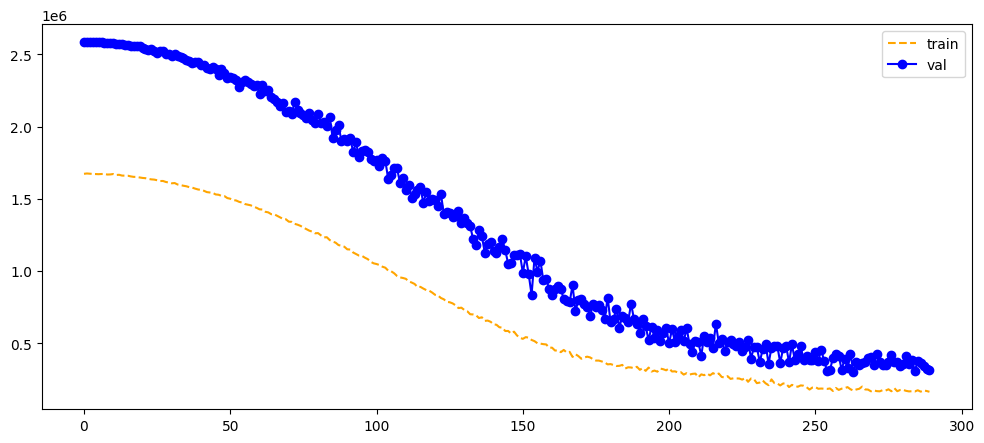

In [84]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

plot_loss(clf.train_loss, clf.val_loss)

In [85]:
# Make sure model is in eval mode
clf.best_model.eval()

# Prepare input
X_val_np = X_val.astype(np.float32)
X_val_tensor = torch.from_numpy(X_val_np).to(clf.device)

# Get predictions
with torch.no_grad():
    y_pred = clf.predict(X_val_tensor).view(-1).cpu().numpy()


In [86]:
expected_length = 195
actual_length = len(y_pred)

if actual_length != expected_length:
    raise ValueError(f"Expected {expected_length} predictions, but got {actual_length}.")

index_values = np.arange(expected_length)

submission_df = pd.DataFrame({
    'index': index_values,
    'Price_euros': y_pred
})

print(submission_df.head())
print(submission_df.tail())

submission_df.to_csv('Submission.csv', index=False)
print("✅ Submission file 'Submission.csv' has been created successfully.")


   index  Price_euros
0      0   571.293701
1      1  2008.265503
2      2   824.626038
3      3  1944.552734
4      4   744.971313
     index  Price_euros
190    190   306.647003
191    191   525.631775
192    192  1447.579346
193    193  1877.978638
194    194  1551.586792
✅ Submission file 'Submission.csv' has been created successfully.


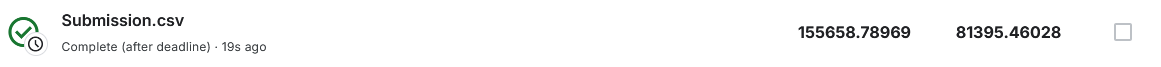

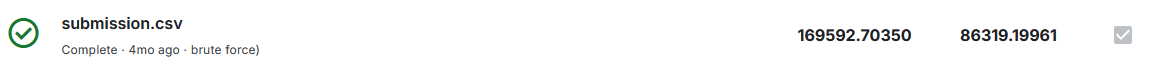